<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 140 (delta 67), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (140/140), 118.41 KiB | 4.08 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 18:41:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [11]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [12]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 143kB 43.6MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 174kB 39.3MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 


In [10]:
!pip install wandb -qq

In [13]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [15]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [16]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: ge9tsbmx
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/ge9tsbmx


In [19]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: iv36taa4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 286ms/step - loss: 0.2090 - mean_squared_error: 0.2090 - mean_absolute_error: 0.3739 - val_loss: 0.1992 - val_mean_squared_error: 0.1992 - val_mean_absolute_error: 0.3883
Epoch 2/200
8/8 [==============================] - 1s 117ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - mean_absolute_error: 0.3138 - val_loss: 0.1408 - val_mean_squared_error: 0.1408 - val_mean_absolute_error: 0.3167
Epoch 3/200
8/8 [==============================] - 1s 123ms/step - loss: 0.1100 - mean_squared_error: 0.1100 - mean_absolute_error: 0.2480 - val_loss: 0.0882 - val_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.2415
Epoch 4/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0649 - mean_squared_error: 0.0649 - mean_absolute_error: 0.1926 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1745
Epoch 5/200
8/8 [==============================] - 1s 121ms/step - loss: 0.0347 - mean_squared_error

wandb: Agent Starting Run: atubnf3x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 8s 196ms/step - loss: 0.2504 - mean_squared_error: 0.2504 - mean_absolute_error: 0.3994 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - val_mean_absolute_error: 0.2760
Epoch 2/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0969 - mean_squared_error: 0.0969 - mean_absolute_error: 0.2556 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.2097
Epoch 3/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0799 - mean_squared_error: 0.0799 - mean_absolute_error: 0.2366 - val_loss: 0.0583 - val_mean_squared_error: 0.0583 - val_mean_absolute_error: 0.2038
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.0728 - mean_squared_error: 0.0728 - mean_absolute_error: 0.2280 - val_loss: 0.0584 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1985
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.0675 - mean_squ

wandb: Agent Starting Run: n4uwfao8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 9s 149ms/step - loss: 0.0746 - mean_squared_error: 0.0746 - mean_absolute_error: 0.1897 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0906
Epoch 2/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0719
Epoch 3/200
31/31 [==============================] - 4s 117ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0362 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0717
Epoch 4/200
31/31 [==============================] - 4s 113ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0354 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0710
Epoch 5/200
31/31 [==============================] - 3s 110ms/step - loss: 0.0022 - mean_squ

wandb: Agent Starting Run: c235o7jf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 10s 173ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1516 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0735
Epoch 2/50
31/31 [==============================] - 3s 112ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0436 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0677
Epoch 3/50
31/31 [==============================] - 3s 112ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0379 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0693
Epoch 4/50
31/31 [==============================] - 3s 110ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0333 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0705
Epoch 5/50
31/31 [==============================] - 3s 110ms/step - loss: 0.0019 - mean_squared

wandb: Agent Starting Run: 1daqjdkq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 10s 160ms/step - loss: 0.1960 - mean_squared_error: 0.1960 - mean_absolute_error: 0.3538 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - val_mean_absolute_error: 0.2485
Epoch 2/200
31/31 [==============================] - 4s 117ms/step - loss: 0.0683 - mean_squared_error: 0.0683 - mean_absolute_error: 0.1974 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1327
Epoch 3/200
31/31 [==============================] - 4s 117ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1483 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1141
Epoch 4/200
31/31 [==============================] - 4s 117ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1282 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0923
Epoch 5/200
31/31 [==============================] - 4s 119ms/step - loss: 0.0176 - mean_sq

wandb: Agent Starting Run: 4bb1ri4z with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 7s 288ms/step - loss: 0.1577 - mean_squared_error: 0.1577 - mean_absolute_error: 0.3165 - val_loss: 0.1067 - val_mean_squared_error: 0.1067 - val_mean_absolute_error: 0.2703
Epoch 2/100
8/8 [==============================] - 1s 126ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - mean_absolute_error: 0.2074 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1519
Epoch 3/100
8/8 [==============================] - 1s 111ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1406 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1123
Epoch 4/100
8/8 [==============================] - 1s 107ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1230 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0915
Epoch 5/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0124 - mean_squared_error

wandb: Agent Starting Run: esohj3uu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 10s 156ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - mean_absolute_error: 0.2093 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0891
Epoch 2/100
31/31 [==============================] - 4s 113ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0719 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0709
Epoch 3/100
31/31 [==============================] - 4s 119ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0487 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0710
Epoch 4/100
31/31 [==============================] - 4s 115ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0475 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0707
Epoch 5/100
31/31 [==============================] - 3s 112ms/step - loss: 0.0041 - mean_sq

wandb: Agent Starting Run: hzw55289 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 8s 199ms/step - loss: 0.2411 - mean_squared_error: 0.2411 - mean_absolute_error: 0.3989 - val_loss: 0.1690 - val_mean_squared_error: 0.1690 - val_mean_absolute_error: 0.3332
Epoch 2/100
16/16 [==============================] - 2s 116ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - mean_absolute_error: 0.2724 - val_loss: 0.0826 - val_mean_squared_error: 0.0826 - val_mean_absolute_error: 0.2239
Epoch 3/100
16/16 [==============================] - 2s 114ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - mean_absolute_error: 0.2384 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1982
Epoch 4/100
16/16 [==============================] - 2s 111ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - mean_absolute_error: 0.2210 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1926
Epoch 5/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0665 - mean_squ

wandb: Agent Starting Run: 68mnfhc2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 201ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2468 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1262
Epoch 2/50
16/16 [==============================] - 2s 116ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1057 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0864
Epoch 3/50
16/16 [==============================] - 2s 117ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0533 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0782
Epoch 4/50
16/16 [==============================] - 2s 120ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0449 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0737
Epoch 5/50
16/16 [==============================] - 2s 124ms/step - loss: 0.0044 - mean_squared_

wandb: Agent Starting Run: q8p59iwp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 207ms/step - loss: 0.1093 - mean_squared_error: 0.1093 - mean_absolute_error: 0.2395 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1480
Epoch 2/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1149 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0952
Epoch 3/200
11/16 [===================>..........] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0651

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 64,
        'dropout': 0.3,
        'input_size': 100,
        'hidden_size': 100,
        'learning_rate': 0.001,
        'optimizer': 'adam',
        'activation': 'selu',
    }

In [20]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='selu'))
model.add(Dropout(0.3))
# hidden layer
model.add(GRU(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  91601


In [21]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=64)

Epoch 1/200
20/20 [==============================] - 5s 89ms/step - loss: 0.0518
Epoch 2/200
20/20 [==============================] - 2s 91ms/step - loss: 0.0052
Epoch 3/200
20/20 [==============================] - 2s 92ms/step - loss: 0.0033
Epoch 4/200
20/20 [==============================] - 2s 94ms/step - loss: 0.0034
Epoch 5/200
20/20 [==============================] - 2s 93ms/step - loss: 0.0033
Epoch 6/200
20/20 [==============================] - 2s 92ms/step - loss: 0.0022
Epoch 7/200
20/20 [==============================] - 2s 88ms/step - loss: 0.0030
Epoch 8/200
20/20 [==============================] - 2s 88ms/step - loss: 0.0025
Epoch 9/200
20/20 [==============================] - 2s 95ms/step - loss: 0.0023
Epoch 10/200
20/20 [==============================] - 2s 90ms/step - loss: 0.0024
Epoch 11/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0022
Epoch 12/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0020
Epoch 13/200
20/20 [=====

In [22]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

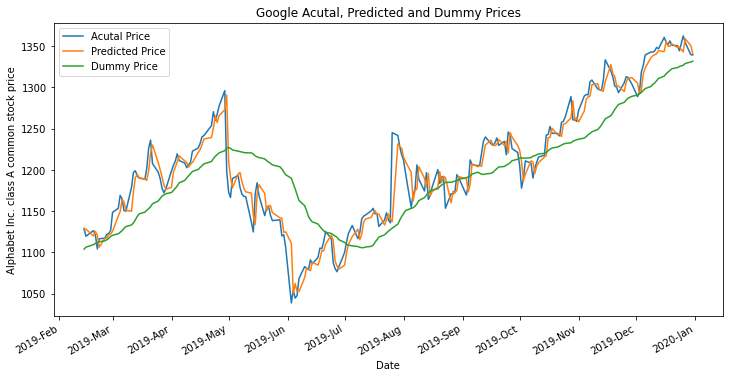

In [23]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

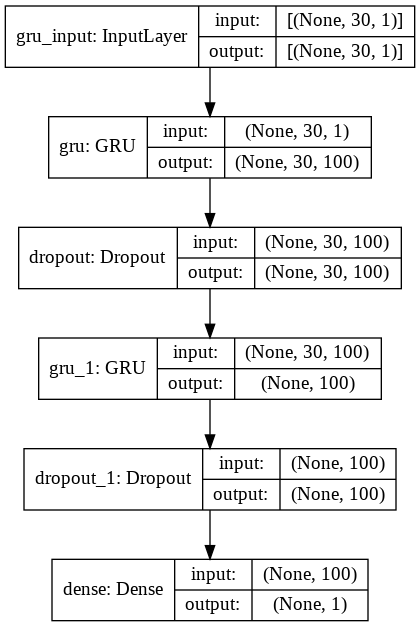

In [24]:
plot_model(model, show_shapes=True, expand_nested=True)

In [25]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0031177966098529055
RMSE:  0.05583723318586717
MAE:  0.03763693769104839


In [26]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Google/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Google/assets
